In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as scisp
import dataclasses as dc
from scipy.io import mmwrite
import pyamg 

In [ ]:
def RobinHelper(alpha,beta,gamma,h,outward=True):
   sign = 1 if outward else -1;
   lapmod = -2*alpha/(beta*h) * sign
   rhsmod = -2*gamma/(beta*h)  * sign
   return lapmod, rhsmod


def ConstructLaplacian(rgf,zgf,Nrf,Nzf,hrf,hzf, bcs: LaplacianBCs):
   Ntot = Nrf * Nzf
   lapmat = scisp.lil_matrix((Ntot, Ntot))
   rhs = np.zeros(Ntot)
   def idx(i, j):
      return j * Nrf + i

   for j in range(Nzf): #Build matrix
      for i in range(Nrf):
         on_left = (i == 0)
         on_right = (i == Nrf - 1)
         on_bottom = (j == 0)
         on_top = (j == Nzf - 1)
         k = idx(i, j)
         lapmat[k, k] = -2 / hrf**2 - 2 / hzf**2 # diagonal element
         if i == 0:
            # first r 
            lapmat[k, k] += -2/hrf**2  # Add extra -2/hrf² to base diagonal
            lapmat[k, idx(i+1, j)] = 4/hrf**2  # Right neighbor (no cylindrical term)
         elif i < Nrf - 1:
            # Interior: left neighbor
            lapmat[k, idx(i-1, j)] = 1/hrf**2 - 1/(2*rgf[i]*hrf)
            # Interior: right neighbor  
            lapmat[k, idx(i+1, j)] = 1/hrf**2 + 1/(2*rgf[i]*hrf)
         else:
            # last r
            lapmat[k, idx(i-1, j)] = 2/hrf**2 - 1/(2*rgf[i]*hrf)
            alpha,beta,gamma = bcs.r_outer.alpha[j], bcs.r_outer.beta[j], bcs.r_outer.gamma[j]
            lapmod, rhsmod = RobinHelper(alpha,beta,gamma,hrf)
            lapmat[k, k] += lapmod 
            rhs[k] += rhsmod

         if j == 0: 
            #firzt z
            lapmat[k, idx(i, j+1)] = 2 / hzf**2  # top neighbor (no z-derivative term)
            alpha,beta,gamma = bcs.z_inner.alpha[i], bcs.z_inner.beta[i], bcs.z_inner.gamma[i]
            lapmod, rhsmod = RobinHelper(alpha,beta,gamma,hzf, outward=False)
            lapmat[k, k] += lapmod 
            rhs[k] += rhsmod
         elif j < Nzf - 1:
            lapmat[k, idx(i, j-1)] = 1 / hzf**2 # bottom neighbor
            lapmat[k, idx(i, j+1)] = 1 / hzf**2 # top neighbor
         else:
            #last z
            lapmat[k, idx(i, j-1)] = 2 / hzf**2 # bottom neighbor
            alpha,beta,gamma = bcs.z_outer.alpha[i], bcs.z_outer.beta[i], bcs.z_outer.gamma[i]
            lapmod, rhsmod = RobinHelper(alpha,beta,gamma,hzf)
            lapmat[k, k] += lapmod 
            rhs[k] += rhsmod

   return lapmat.tocsr(), rhs



def alpha_anzatz(rgf, E0omf, rmaxf):
  return (E0omf + (rgf - rmaxf)/(2.0*rmaxf))/(1 + (rgf - rmaxf)/(2.0*rmaxf))


def calc_sigma(rgf,lapf, E0omf, rmaxf, K0f, Mguessf):
  result = (rgf <= rmaxf)*2*np.pi*K0f*(E0omf**2)*lapf**(-3.0)/Mguessf
  return result

def calc_bigsigma(sigmaf, alpha, E0omf):
   return(sigmaf*( 1 - (alpha/E0omf)**2 ))
         

            
class RazorThinDisk:
   def __init__(self, Nr, Nz, r_maxfac, z_maxfac, E0oM,K0, solmeth):
         self.Nr = Nr
         self.Nz = Nz
         self.solmeth = solmeth

         self.E0oM = E0oM
         self.Mguess = 1.0 # Initial guess for M_ADM
         self.rmaxguess = self.Mguess*0.5*(1 + self.E0oM)/(1 - self.E0oM)
         self.K0 = K0

         self.rgridmin = 0.0; self.rgridmax = r_maxfac*self.Mguess
         self.zgridmin = 0.0; self.zgridmax = z_maxfac*self.Mguess
         self.Lr = self.rgridmax - self.rgridmin; self.Lz = self.zgridmax - self.zgridmin;
         self.hr, self.hz = self.Lr/(self.Nr - 1), self.Lz/(self.Nz - 1)

         self.rhog = np.linspace(self.rgridmin, self.rgridmax, self.Nr, endpoint = True)
         self.zg = np.linspace(self.zgridmin, self.zgridmax, self.Nz, endpoint = True)
         self.rhog2d, self.zg2d = np.meshgrid(self.rhog, self.zg, indexing='ij')
         
         self.r_disp = np.sqrt(self.rhog2d**2 + self.zg2d**2)
        
         self.r_top = np.sqrt(self.rhog**2 + self.zg[-1]**2)
         self.r_right = np.sqrt(self.rhog[-1]**2 + self.zg**2)

         self.lapse_old = alpha_anzatz(self.rhog, self.E0oM, self.rmaxguess)
         self.psi_old = np.ones(Nr)
         self.sigma_old = calc_sigma(self.rhog, self.lapse_old, self.E0oM, self.rmaxguess, self.K0, self.Mguess)
         self.bigsigma_old = calc_bigsigma(self.sigma_old, self.lapse_old, self.E0oM) 

         self.bcs_psi = LaplacianBCs(
               r_inner = RobinBC(alpha=np.zeros(Nz), beta=np.ones(Nz), gamma=np.zeros(Nz)), #r- DUMMY
               r_outer = RobinBC(alpha=np.ones(Nz), beta=self.r_right**2/self.rhog[-1], gamma=np.ones(Nz)), #r+
               z_inner = RobinBC(alpha=np.zeros(Nr), beta=np.ones(Nr), gamma =-np.pi*self.sigma_old*self.psi_old**5),
               #z_inner = RobinBC(alpha=5*np.pi*(self.psi_old**4)*self.sigma_old, beta=np.ones(Nr), gamma=4*np.pi*self.psi_old**5*self.sigma_old), #z-
               z_outer = RobinBC(alpha=np.ones(Nr), beta=self.r_top**2/self.zg[-1], gamma=np.ones(Nr))  #z+
            )
      
         self.bcs_psilapse = LaplacianBCs(
               r_inner = RobinBC(alpha=np.zeros(Nz), beta=np.ones(Nz), gamma=np.zeros(Nz)), #r- DUMMY
               r_outer = RobinBC(alpha=np.ones(Nz), beta=self.r_right**2/self.rhog[-1], gamma=np.ones(Nz)), #r+
               # z_inner = RobinBC(alpha=np.zeros(Nr), beta=np.ones(Nr), gamma =np.pi*self.lapse_old*self.psi_old**5 *\
               #                     (self.sigma_old + 2*self.bigsigma_old) ), #z-
               z_inner = RobinBC(alpha=-np.pi*(self.psi_old**4)*(self.sigma_old + 2*self.bigsigma_old), \
                                 beta=np.ones(Nr), gamma=np.zeros(Nr)), #z- alternative, 
               #z_inner = RobinBC(alpha=5*np.pi*(self.psi_old**4)*self.sigma_old, beta=np.ones(Nr), gamma=4*np.pi*self.psi_old**5*self.sigma_old), #z-
               z_outer = RobinBC(alpha=np.ones(Nr), beta=self.r_top**2/self.zg[-1], gamma=np.ones(Nr))  #z+
            )
         

         self.lapmat_psi, self.rhs_psi = ConstructLaplacian(self.rhog, self.zg, self.Nr, self.Nz, self.hr, self.hz, self.bcs_psi)
         self.lapmat_psilapse, self.rhs_psilapse = ConstructLaplacian(self.rhog, self.zg, self.Nr, self.Nz, self.hr, self.hz, self.bcs_psilapse)
         
         self.r_innerbndy = np.arange(0, self.Nz) * self.Nr
         self.r_outerbndy = np.arange(self.Nr-1, self.Nr*self.Nz, self.Nr)
         self.z_innerbndy = np.arange(0, self.Nr)
         self.z_outerbndy = np.arange(self.Nr*(self.Nz-1), self.Nr*self.Nz)
         self.boundary = np.unique(np.concatenate([self.r_innerbndy, self.r_outerbndy, self.z_innerbndy, self.z_outerbndy]))
         self.interior = np.setdiff1d(np.arange(self.Nr*self.Nz), self.boundary)
         self.interior2d = np.ix_(np.arange(1,self.Nr-1), np.arange(1,self.Nz-1))

         self.itmax = 1e4; self.step = 0; self.tol_target = 1e-8; self.tol = 1.0;
   
         self.psis = [self.psi_old]
         self.psilapses = [self.lapse_old*self.psi_old]
         self.lapses = [self.lapse_old]
         self.sigmas = [self.sigma_old]
         self.bigsigmas = [self.bigsigma_old]
         self.rmaxes = [self.rmaxguess]

         #Initializing
         # match(self.solmeth):
         #    case 0:
         #       #print("Using sparse direct solver")
         #       pass
         #    case 1:
         #       #print("Using GMRES iterative solver")
         #       pass
         #    case 2:
         #       #print("Using multigrid solver")
         #       self.ml = pyamg.smoothed_aggregation_solver(self.lapmat_psi) # Setup the multigrid hierarchy, only values change.
         #       self.ml_pre = self.ml.aspreconditioner() # Get the multigrid preconditioner

         # print("rhs norm", np.linalg.norm(self.rhs_psi))
         # print("A nnz", self.lapmat_psi.nnz)
         # #print("A det", np.linalg.det(self.lapmat.toarray()))
         # print("A shape", self.lapmat_psi.shape)

   def Iterate(self):
      
      self.psi_new, self.psilapse_new, self.lapse_new = self.Solve_PsiLapse_Lapse(\
         self.lapmat_psi, self.rhs_psi, self.lapmat_psilapse, self.rhs_psilapse) 

      
      # self.psires = self.lapmat_psi @ self.psi_new - self.rhs_psi
      # self.psilapseres = self.lapmat_psilapse @ self.psilapse_new - self.rhs_psilapse

      # print(f'-------------------')
      # print("psi res norm", np.linalg.norm(self.psires))
      # print("psi rel res", np.linalg.norm(self.psires)/np.linalg.norm(self.rhs_psi))
      # print("psi res int. norm", np.linalg.norm(self.psires[self.interior]))
      # print("psi res bndy norm", np.linalg.norm(self.psires[self.boundary]))
      # print("psi max", np.max(self.psi_new))
      # print("psi min", np.min(self.psi_new))
      # print(f'')

      # print("psi*lapse res norm", np.linalg.norm(self.psilapseres))
      # print("psi*lapse rel res", np.linalg.norm(self.psilapseres)/np.linalg.norm(self.rhs_psilapse))
      # print("psi*lapse res int. norm", np.linalg.norm(self.psilapseres[self.interior]))
      # print("psi*lapse res bndy norm", np.linalg.norm(self.psilapseres[self.boundary]))
      # print("lapse max", np.max(self.lapse_new))
      # print("lapse min", np.min(self.lapse_new))
      # print(f'-------------------')

      
      self.psi_new2d = self.psi_new.reshape((self.Nz, self.Nr), order='C').T
      self.psilapse_new2d = self.psilapse_new.reshape((self.Nz, self.Nr), order='C').T
      self.lapse_new2d = self.lapse_new.reshape((self.Nz, self.Nr), order='C').T
      if np.max(self.lapse_new[:self.Nr]) < self.E0oM:
         self.rmax_it = self.Nr - 1
      else:
         self.rmax_it = np.argmax(self.lapse_new[:self.Nr] >= self.E0oM) -1
      #print(self.lapse_new[0])
      #print(self.rmax_it)
      #print(self.rhog[self.rmax_it])
      self.sigma_new = calc_sigma(self.rhog, self.lapse_new[:self.Nr], self.E0oM, self.rhog[self.rmax_it], self.K0, self.Mguess) #Wrong
      #print(self.sigma_new)
      self.bigsigma_new = calc_bigsigma(self.sigma_new, self.lapse_new[:self.Nr], self.E0oM) #wrong
      
      
   def Solve_PsiLapse_Lapse(self, lapmat_psi, rhs_psi, lapmat_psilapse, rhs_psilapse):
      match (self.solmeth):
         case 0:
            #Sparse solver
            psi_new = scisp.linalg.spsolve(lapmat_psi, rhs_psi)
            psilapse_new = scisp.linalg.spsolve(lapmat_psilapse, rhs_psilapse)
         case 1:
            #gmres, slow?
            psi_new, self.info_psi = scisp.linalg.gmres(lapmat_psi, rhs_psi, rtol=1e-8)
            psilapse_new, self.info_psilapse = scisp.linalg.gmres(lapmat_psilapse, rhs_psilapse, rtol=1e-8)
            #print(self.info_psi, self.info_psilapse)
         case 2:
            #Multigrid solver
            self.ml_psi = pyamg.ruge_stuben_solver(lapmat_psi) # Setup the multigrid hierarchy
            self.ml_psilapse = pyamg.ruge_stuben_solver(lapmat_psilapse) # Setup the multigrid hierarchy
            psi_new = self.ml_psi.solve(rhs_psi, tol=1e-10) # Solve the system
            psilapse_new = self.ml_psilapse.solve(rhs_psilapse, tol=1e-10) # Solve the system

      lapse_new = psilapse_new/psi_new
      return psi_new, psilapse_new, lapse_new

   def Eval_BC_Residuals_Manual(self,psi2d_n, psilap2d_n, psi2d_o, psilap2d_o):
      sigma_t = calc_sigma(self.rhog, psilap2d_o[:,0], self.E0oM, self.rmaxguess, self.K0, self.Mguess)
      bigsigma_t = calc_bigsigma(sigma_t, psi2d_o[:,0], self.E0oM)
      psi_nor = psi2d_n[-1,:] #r+
      psi_noz = psi2d_n[:, -1] #z+
      psilap_nor = psilap2d_n[-1,:] #r+
      psilap_noz = psilap2d_n[:, -1] #z+
      rdisp_or = self.r_disp[-1,:] #rdisp at r+
      rdisp_oz = self.r_disp[:,-1] #rdisp at z+
      fdcoefs = np.array([-147,360,-450,400,-225,72,-10])/60 #7th order fd coefs for 1st derivative one sided
      fdcoefs2 = fdcoefs[::-1]
      dzpsi_z0 = np.sum(fdcoefs[:,np.newaxis]* psi2d_n[:7,:],axis=0) / self.hz
      dzpsi_zp = np.sum(fdcoefs2[:,np.newaxis]* psi2d_n[-7:,:],axis=0) / self.hz
      dzpsilap_z0 = np.sum(fdcoefs[:,np.newaxis]* psilap2d_n[:7,:],axis=0) / self.hz
      dzpsilap_zp = np.sum(fdcoefs2[:,np.newaxis]* psilap2d_n[-7:,:],axis=0) / self.hz
      drpsi_rp = np.sum(fdcoefs2[np.newaxis,:]* psi2d_n[:,-7:],axis=1) / self.hr
      drpsilap_rp = np.sum(fdcoefs2[np.newaxis,:]* psilap2d_n[:,-7:],axis=1) / self.hr

      lap_psi = np.gradient(np.gradient(psi2d_n,self.hr,axis=0), self.hr,axis=0) +\
                  np.gradient(np.gradient(psi2d_n,self.hz,axis=1), self.hz,axis=1) +\
                  np.gradient(psi2d_n,self.hr,axis=0)/(self.r_disp + 1e-9)
      
      lap_psilapse = np.gradient(np.gradient(psilap2d_n,self.hr,axis=0), self.hr,axis=0) +\
                  np.gradient(np.gradient(psilap2d_n,self.hz,axis=1), self.hz,axis=1) +\
                  np.gradient(psilap2d_n,self.hr,axis=0)/(self.r_disp + 1e-9)
      
      resid_psiV   = np.sqrt(np.sum(np.square(lap_psi[1:-1,1:-1])))         * self.hr*self.hz
      resid_psilapseV = np.sqrt(np.sum(np.square(lap_psilapse[1:-1,1:-1]))) * self.hr*self.hz

      resid_psi_rp   = np.sqrt(np.sum(np.square(psi_nor - (rdisp_or**2 / self.rhog[-1])*drpsi_rp - 1.0)))          * self.hz
      resid_psi_zp   = np.sqrt(np.sum(np.square(psi_noz - (rdisp_oz**2 / self.zg[-1])*dzpsi_zp - 1.0  )))          * self.hr
      resid_psilapse_rp = np.sqrt(np.sum(np.square(psilap_nor - (rdisp_or**2 / self.rhog[-1])*drpsilap_rp - 1.0))) * self.hz
      resid_psilapse_zp = np.sqrt(np.sum(np.square(psilap_noz - (rdisp_oz**2 / self.zg[-1])*dzpsilap_zp - 1.0  ))) * self.hr

      resid_psi_z0  = np.sqrt(np.sum(np.square(dzpsi_z0 + np.pi*psi2d_n[:,0]**5 * sigma_t ))) * self.hr
      resid_psilapse_z0 = np.sqrt(np.sum(np.square(dzpsilap_z0 - np.pi*psilap2d_n[:,0]*psi2d_n[:,0]**5 * (sigma_t + 2*bigsigma_t) ))) * self.hr

      print(f'Vol. resid. psi: {resid_psiV:.3e}, psi*lapse: {resid_psilapseV:.3e}')
      print(f'Bndy r+ resid. psi: {resid_psi_rp:.3e}, psi*lapse: {resid_psilapse_rp:.3e}')
      print(f'Bndy z+ resid. psi: {resid_psi_zp:.3e}, psi*lapse: {resid_psilapse_zp:.3e}')
      print(f'Bndy z0 resid. psi: {resid_psi_z0:.3e}, psi*lapse: {resid_psilapse_z0:.3e}')


   def Visualize(self, psi_new):
      plt.figure()
      plt.imshow(psi_new.T, origin='lower', extent=(self.rgridmin, self.rgridmax, self.zgridmin, self.zgridmax))
      plt.colorbar(label=r'$\psi$')
      plt.xlabel('r')
      plt.ylabel('z')
      plt.title(rf'Solution $\psi$(r,z)')
      
   def Visualize1D(self, psi_new,psilapse_new):
      zslices = np.arange(0, self.Nz, self.Nz//5)
      rslices = np.arange(0, self.Nr, self.Nr//5)
      maskfix = 0.7
      rhog_omask = self.rhog >= maskfix*self.rmaxguess
      zg_omask = self.zg >= maskfix*self.rmaxguess
      zidx = np.array([np.argmin(np.abs(self.zg - self.zg[zslices[i]])) for i in range(len(zslices))])
      ridx = np.array([np.argmin(np.abs(self.rhog - self.rhog[rslices[i]])) for i in range(len(rslices))])
      fig, axs = plt.subplots(2, 2, figsize=(16,16))
      rslzmaskr = self.r_disp[rhog_omask,:][:,zidx]
      rslrmaskz = self.r_disp[:,zg_omask][ridx,:]
      fitpr = -1#-self.Nr//4
      fitpz = -1#-self.Nz//4
      axs[0,0].plot(self.rhog, psi_new[:,zidx], "-o", label=[f'z={self.zg[idx]:.2f}' for idx in zidx])
      axs[0,0].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[0,0].plot(self.rhog[rhog_omask], 1+((psi_new[fitpr,zidx]-1) * (rslzmaskr[fitpr,:]/(rslzmaskr+1e-9))**1.0) , "--",c='k', scaley=False)
      axs[0,0].set_xlabel('r')
      axs[0,0].set_ylabel(rf'$\psi$')
      axs[0,0].set_title(rf'Solution $\psi$(r, z=idx)')
      axs[0,0].legend()
      #axs[0,0].set_xscale('log')
      #axs[0,0].set_yscale('log')
      axs[0,0].grid()
      #axs[0,0].set_ylim(0.98*np.min(self.ures2d[:,zidx]), 1.02*np.max(self.ures2d[:,zidx]))

      axs[1,0].plot(self.zg, psi_new[ridx,:].T, "-o", label=[f'r={self.rhog[idx]:.2f}' for idx in ridx])
      #axs[1,0].plot(self.zg, ures2d[0,10]*(self.r_disp[0,10])/self.r_disp[:,10] - 1.0, "--",c='k')
      axs[1,0].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[1,0].plot(self.zg[zg_omask], 1+((psi_new[ridx,np.newaxis,fitpz]-1) * (rslrmaskz[:,fitpz,np.newaxis]/(rslrmaskz+1e-9))**1.0).T, "--",c='k', scaley=False)
      axs[1,0].set_xlabel('z')
      axs[1,0].set_ylabel(rf'$\psi$')
      axs[1,0].set_title(rf'Solution $\psi$(r=idx, z)')
      axs[1,0].legend()
      #axs[1,0].set_xscale('log')
      #axs[1,0].set_yscale('log')
      axs[1,0].grid()

      axs[0,1].plot(self.rhog, psilapse_new[:,zidx], "-o", label=[f'z={self.zg[idx]:.2f}' for idx in zidx])
      axs[0,1].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[0,1].plot(self.rhog[rhog_omask], 1+((psilapse_new[fitpr,zidx]-1) * (rslzmaskr[fitpr,:]/(rslzmaskr+1e-9))**1.0) , "--",c='k', scaley=False)
      axs[0,1].set_xlabel('r')
      axs[0,1].set_ylabel(rf'$\psi*\alpha$')
      axs[0,1].set_title(rf'$\psi*\alpha$(r, z=idx)')
      axs[0,1].legend()
      #axs[0,1].set_xscale('log')
      #axs[0,1].set_yscale('log')
      axs[0,1].grid()
      axs[1,1].plot(self.zg, psilapse_new[ridx,:].T, "-o", label=[f'r={self.rhog[idx]:.2f}' for idx in ridx])
      #axs[1,1].plot(self.zg, ures2d[10,0]*(self.r_disp[10,0])/self.r_disp[10,:] - 1.0, "--",c='k')
      axs[1,1].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[1,1].plot(self.zg[zg_omask], 1+((psilapse_new[ridx,np.newaxis,fitpz]-1) * (rslrmaskz[:,fitpz,np.newaxis]/(rslrmaskz+1e-9))**1.0).T, "--",c='k', scaley=False)
      axs[1,1].set_xlabel('z')
      axs[1,1].set_ylabel(rf'$\psi*\alpha$')
      axs[1,1].set_title(rf'$\psi*\alpha$(r=idx, z)')
      axs[1,1].legend()
      #axs[1,1].set_xscale('log')
      #axs[1,1].set_yscale('log')
      axs[1,1].grid()

      fig.tight_layout()
      #axs[1].set_ylim(0.98*np.min(self.ures2d[ridx,:]), 1.02*np.max(self.ures2d[ridx,:]))

   def VisualizeSigmaAlphaPsi(self, sigmas,bigsigmas,lapses,psis):
      fig, axs = plt.subplots(2,2, figsize=(16,16))
      for i in range(len(sigmas)):
         sigma = sigmas[i]
         axs[0,0].plot(self.rhog, sigma, "-o", label=f'Iter {i}')
      axs[0,0].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[0,0].set_title('Sigma(r)')
      axs[0,0].set_xlabel('r')
      axs[0,0].set_ylabel('Sigma')
      axs[0,0].legend()
      for i in range(len(lapses)):
         lapse = lapses[i]
         axs[0,1].plot(self.rhog, lapse, "-o", label=f'Iter {i}')
      axs[0,1].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[0,1].set_title('Lapse(r)')
      axs[0,1].set_xlabel('r')
      axs[0,1].set_ylabel(rf'Lapse $\alpha$')
      axs[0,1].legend()
      for i in range(len(psis)):
         psi = psis[i]
         axs[1,1].plot(self.rhog, psi, "-o", label=f'Iter {i}')
      axs[1,1].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[1,1].set_title('Psi(r)')
      axs[1,1].set_xlabel('r')
      axs[1,1].set_ylabel('Psi')
      axs[1,1].legend()
      for i in range(len(psis)):
         bigsig = bigsigmas[i]
         axs[1,0].plot(self.rhog, bigsig, "-o", label=f'Iter {i}')
      axs[1,0].axvline(x =self.rmaxguess,c='k',ls='--')
      axs[1,0].set_title('Big Sigma(r)')
      axs[1,0].set_xlabel('r')
      axs[1,0].set_ylabel('Big Sigma')
      axs[1,0].legend()
      plt.tight_layout()
   
   def VisualizeScaling(self, psi_new):
      r_outerz = self.r_disp[:,-1]
      r_outerr = self.r_disp[-1,:]
      const_outerz = (psi_new[:,-1] - 1.0 ) #* r_outerz
      const_outerr = (psi_new[-1,:] - 1.0 ) #* r_outerr
      plt.figure()
      plt.plot(1/r_outerr, const_outerr, "-o", label='r bndy')
      plt.plot(1/r_outerz, const_outerz, "-o", label='z bndy')
      #plt.axvline(x =self.rmaxguess,c='k',ls='--')
      plt.xlabel('1/r_disp')
      plt.ylabel(rf'$(\psi - 1) ')
      plt.title(rf'$(\psi - 1)')
      plt.legend()
      plt.grid()
      



@dc.dataclass
class RobinBC:
    alpha: np.ndarray
    beta: np.ndarray
    gamma:  np.ndarray

@dc.dataclass
class LaplacianBCs:
   r_inner: RobinBC
   r_outer: RobinBC
   z_inner: RobinBC
   z_outer: RobinBC


Rdisk = RazorThinDisk(Nr=100, Nz=100,r_maxfac = 10, z_maxfac = 10, E0oM=0.8,K0 = 1.0e-2, solmeth = 2)
Rdisk.Iterate()
# Rdisk.Eval_BC_Residuals_Manual(Rdisk.psi_new2d, Rdisk.psilapse_new2d, Rdisk.psi_new2d, Rdisk.psilapse_new2d)


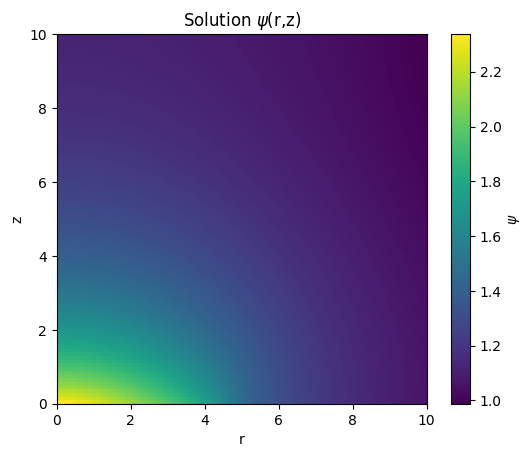

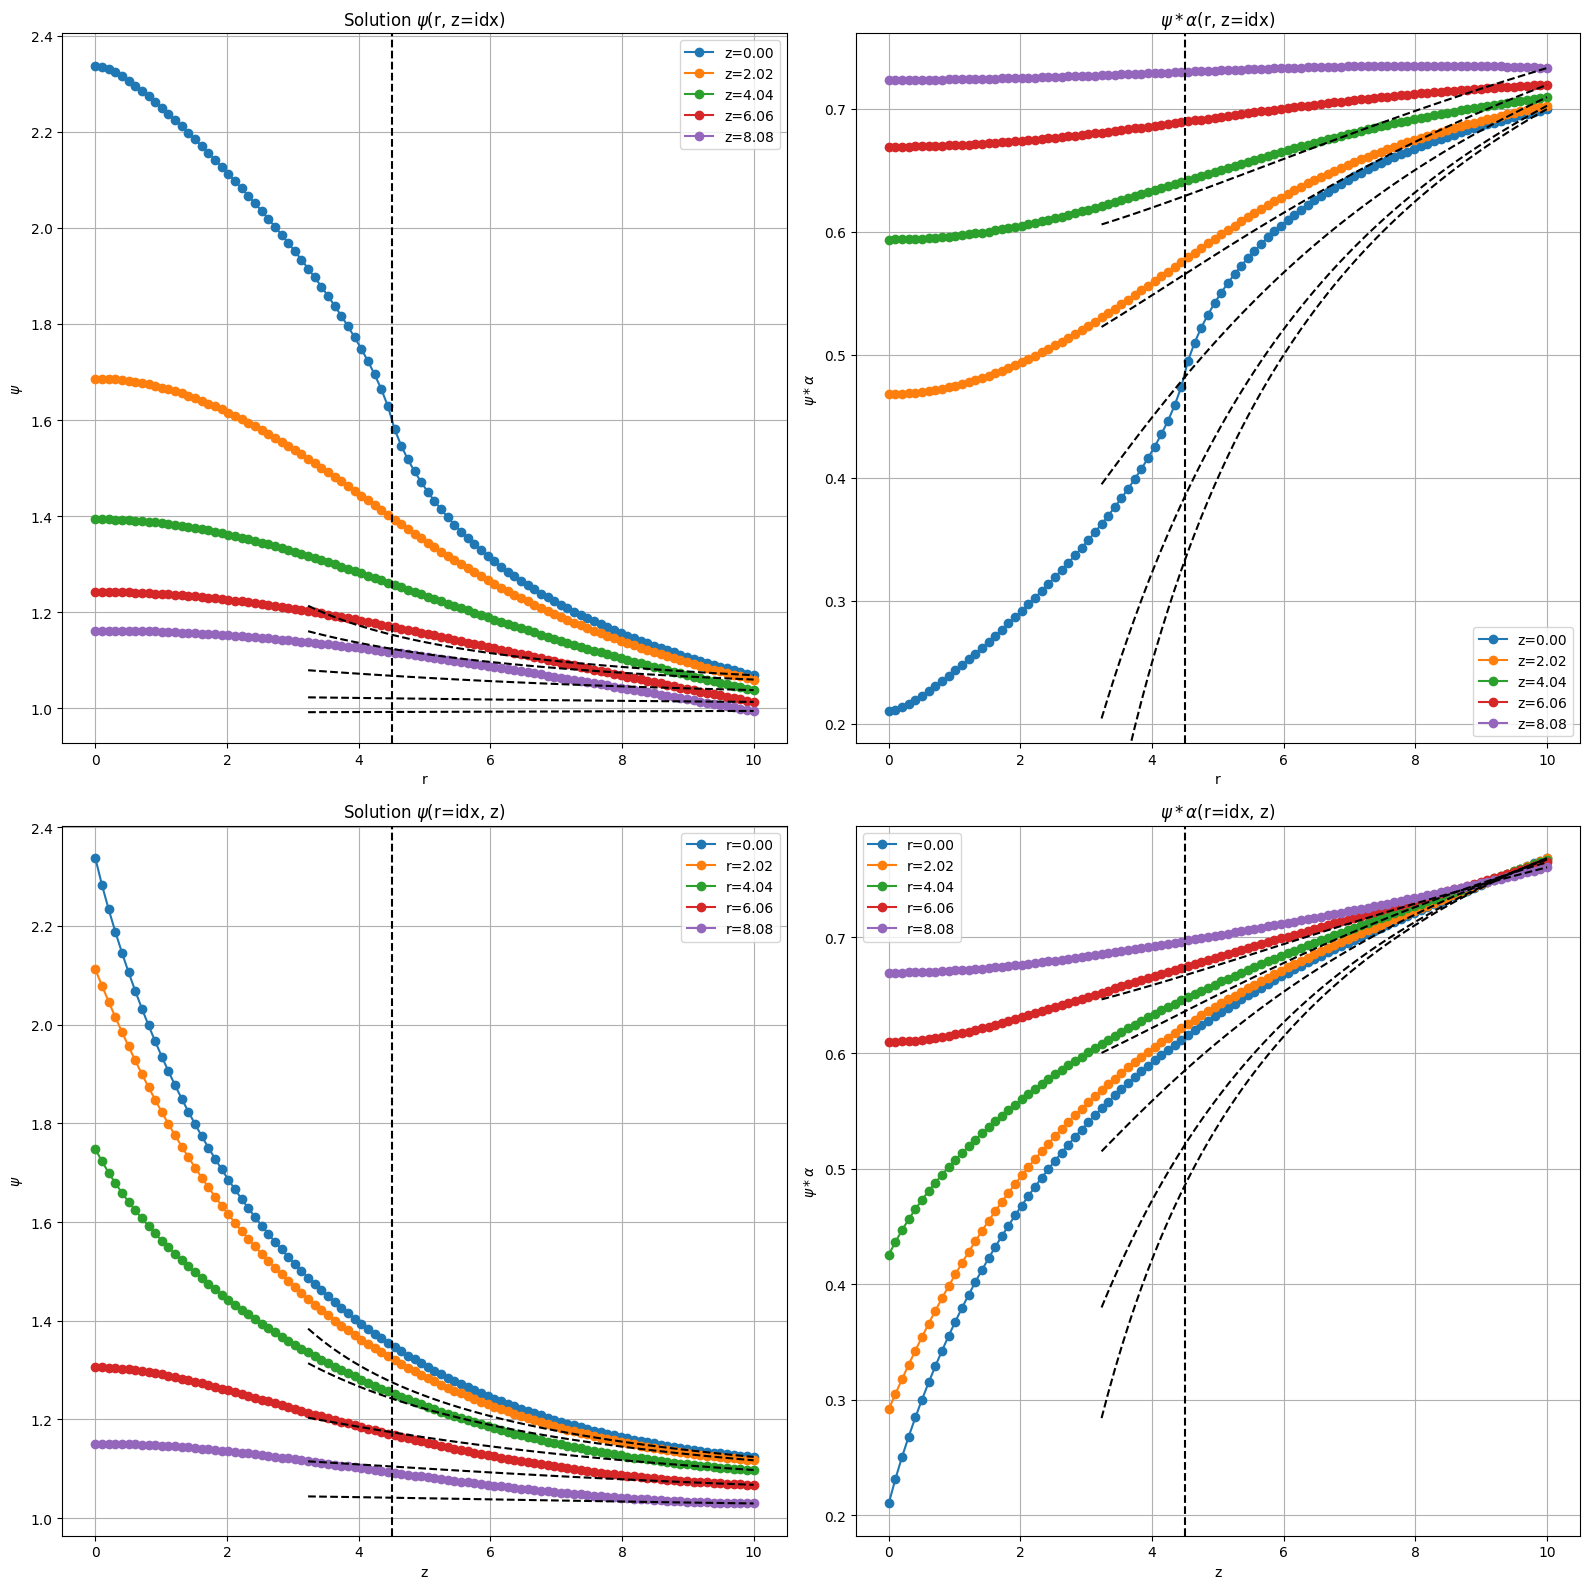

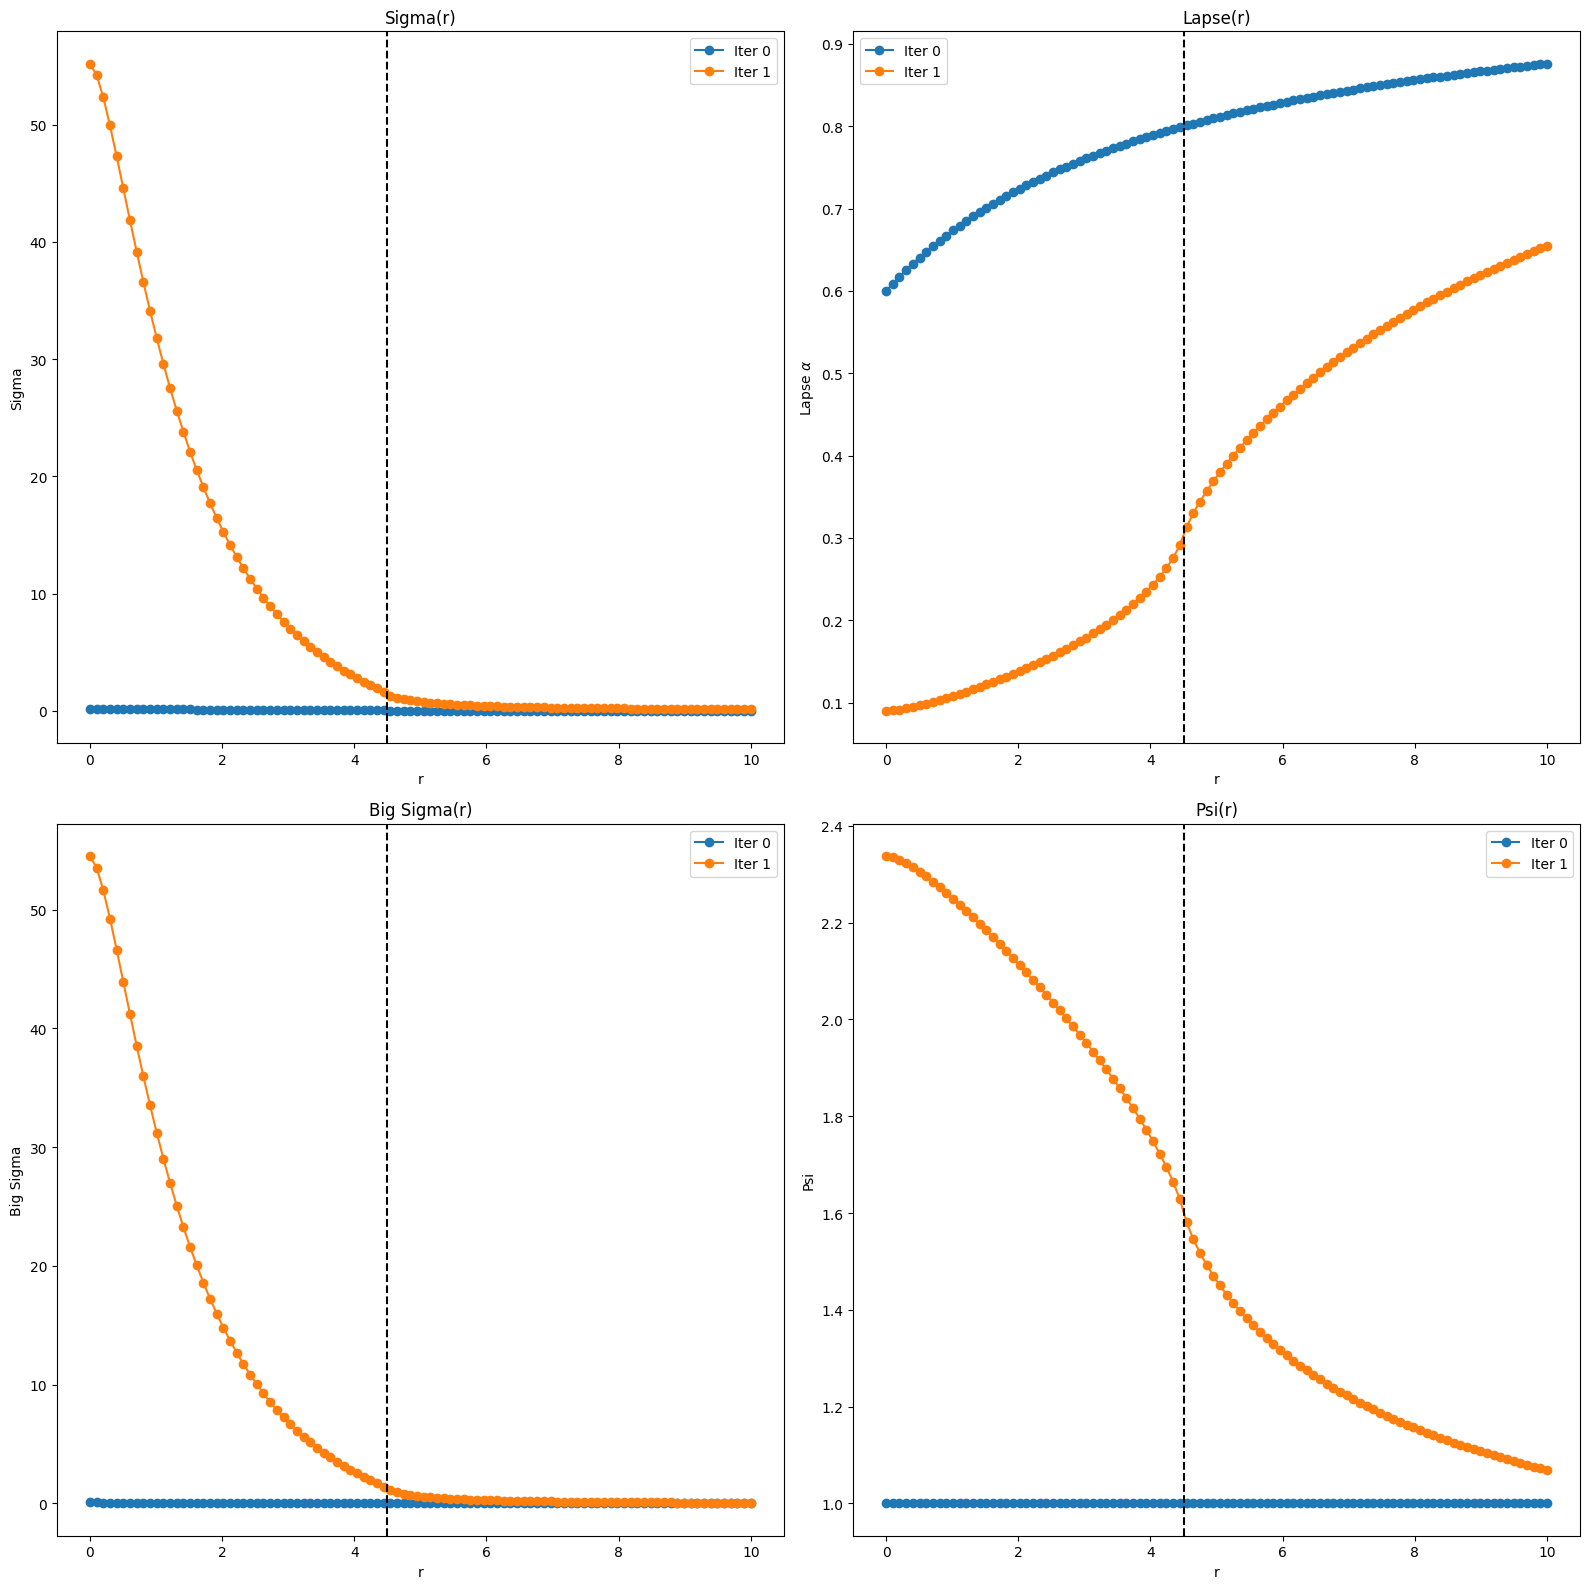

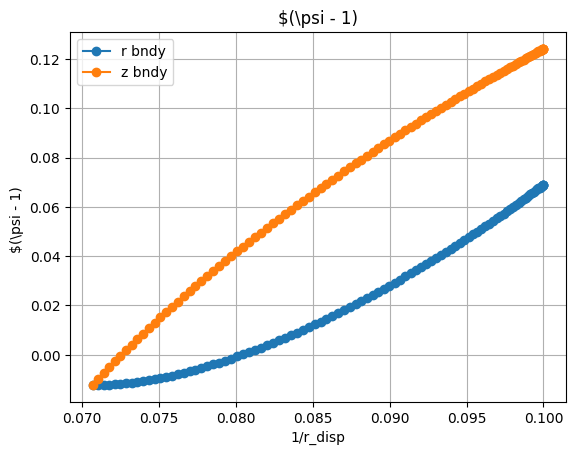

In [124]:
Rdisk.Visualize(Rdisk.psi_new2d)
Rdisk.Visualize1D(Rdisk.psi_new2d, Rdisk.psilapse_new2d)
Rdisk.VisualizeSigmaAlphaPsi([Rdisk.sigma_old, Rdisk.sigma_new],[Rdisk.bigsigma_old, Rdisk.bigsigma_new],\
                              [Rdisk.lapse_old, Rdisk.lapse_new[:Rdisk.Nr]],[Rdisk.psi_old, Rdisk.psi_new[:Rdisk.Nr]])
Rdisk.VisualizeScaling(Rdisk.psi_new2d)

In [ ]:
mmwrite("laplacian.mtx", Rdisk.lapmat)